In [65]:
import cv2
from  matplotlib import pyplot as plt
%matplotlib inline


In [66]:
def cv_show(name,img):
    cv2.namedWindow(name,0)
    cv2.resizeWindow(name,700,900)
    cv2.imshow(name,img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [67]:
imgfile = './images/book.jpg'
raw_img = cv2.imread(imgfile)

cv_show("origin_book", raw_img)

In [68]:
gray_img = cv2.imread(imgfile,
                      cv2.IMREAD_GRAYSCALE)  #Y = 0.299R + 0.587G + 0.114B
cv_show("gray_book", gray_img)
cv2.imwrite('results/book/gray_book.jpg', gray_img)

True

C:\Users\user\AppData\Local\Temp\ipykernel_32572\3463449099.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist = np.histogram(gray_img, bins=np.arange(0, 256), normed=True)


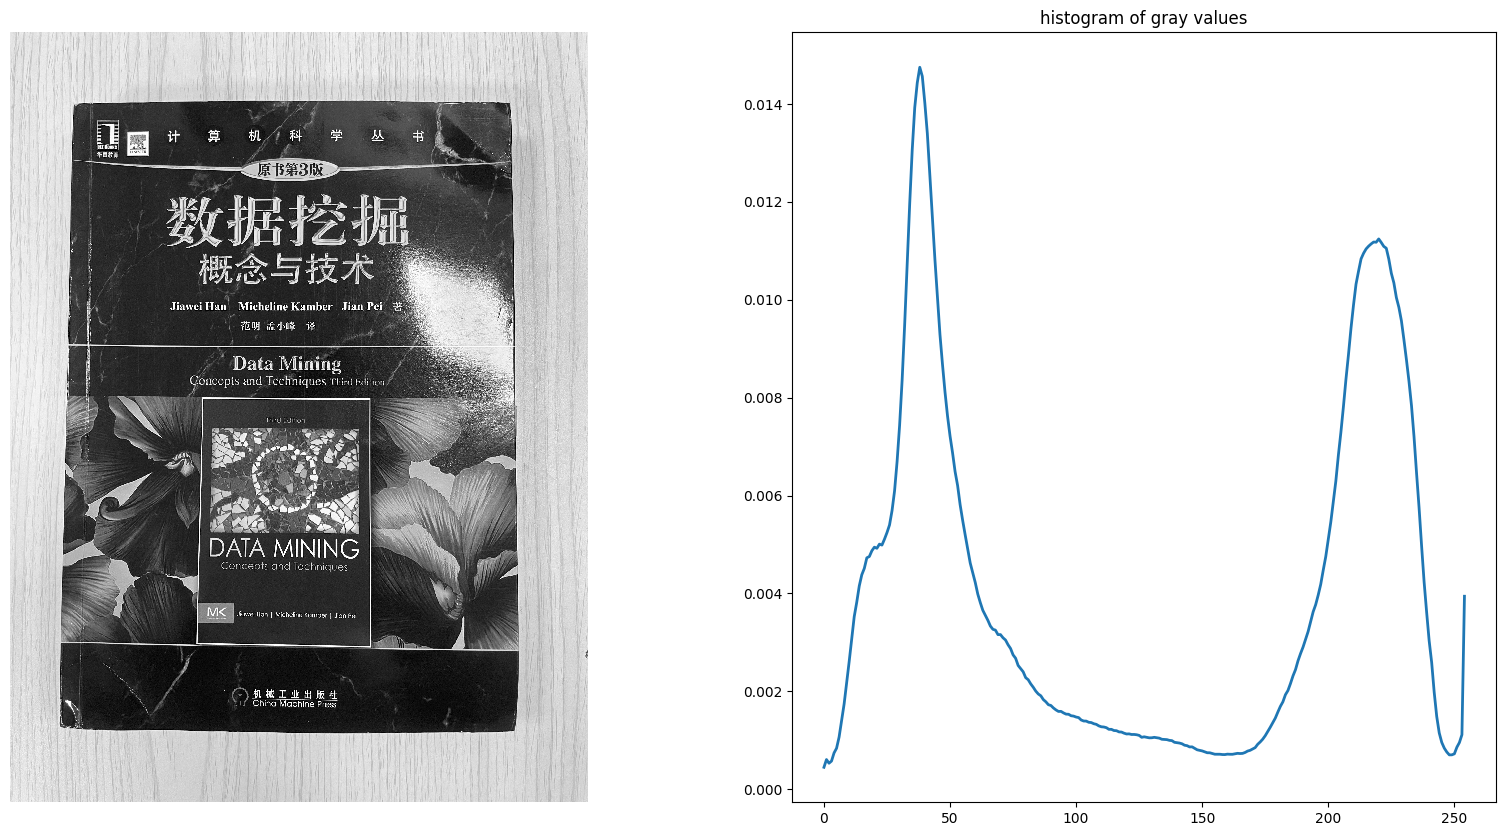

In [69]:
import numpy as np
hist = np.histogram(gray_img, bins=np.arange(0, 256), normed=True)
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(gray_img, cmap=plt.cm.gray, interpolation='nearest')
axes[0].axis('off')
axes[1].plot(hist[1][:-1], hist[0], lw=2)
axes[1].set_title('histogram of gray values')
plt.show()

In [70]:
t0=170
segmented_gray_img = np.where(gray_img[...,:] < t0, 255, 0).astype(np.uint8)

cv_show('segmented_gray_image',segmented_gray_img)

In [71]:
def img_morph(img, size=5, method='open'):
    '''
    img: binary image
    size: the size of square used to do morphological filtering
    method: open or close or erode or dilate
    '''
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (size, size))
    if method == 'open':
        img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    elif method == 'close':
        img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    elif method == 'erode':
        img = cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel)
    elif method == 'dilate':
        img = cv2.morphologyEx(img, cv2.MORPH_DILATE, kernel)

    return img

In [72]:
eroded_book=img_morph(segmented_gray_img,size=10,method='erode')
cv_show('eroded_image', eroded_book)

closed_book=img_morph(eroded_book,size=500,method='close')
cv_show('closed_book', closed_book)

fin_book=img_morph(closed_book,size=10,method='erode')
cv_show('fin_book', fin_book)

In [73]:
segmented_book=cv2.bitwise_and(raw_img,raw_img,mask=fin_book)
cv_show('segmented_book', segmented_book)
cv2.imwrite('results/book/segmented_threshold_book.jpg', segmented_book)

True

In [74]:
def region_grow(img, seeds, threshold):
    '''
    select the bgd pixel attentionally to simplify the problem
    img: gray scale image
    seeds: the seed pixels
    '''
    seed_list = seeds
    neighbors = [[-1,-1],[-1,0],[-1,1],[0,-1],[0,1],[1,-1],[1,0],[1,1]]
    is_search = np.zeros(img.shape)
    is_add = np.zeros(img.shape)
    for seed in seeds:
        is_add[seed[0], seed[1]] = 1
    grow_img = np.ones(img.shape).astype(np.uint8)*255
    # mean_value = img[seed[0], seed[1]]
    cnt = 1
    while(len(seed_list)>0):
        cnt += 1
        seed = seed_list.pop()
        grow_img[seed[0], seed[1]] = 0
        # print(len(seed_list))
        is_search[seed[0], seed[1]] = 1
        for neighbor in neighbors:
            # print(neighbor, seed)
            neighbor_x = seed[0]+neighbor[0]
            neighbor_y = seed[1]+neighbor[1]
            if neighbor_x < 0 or neighbor_y < 0 or neighbor_x >= img.shape[0] or neighbor_y >= img.shape[1]:
                continue
            elif is_search[neighbor_x, neighbor_y] == 1 or is_add[neighbor_x, neighbor_y] == 1:
                continue
            # elif abs(img[neighbor_x, neighbor_y] - mean_value) > threshold:
            elif abs(float(img[neighbor_x, neighbor_y]) - float(img[seed[0],seed[1]])) > threshold:
                continue
            else:
                seed_list.insert(0, [neighbor_x, neighbor_y])
                is_add[neighbor_x, neighbor_y] = 1
                # mean_value = mean_value/cnt+img[neighbor_x, neighbor_y]/cnt
                # print(mean_value)
                # grow_img[neighbor_x, neighbor_y] = 0
    return grow_img

In [75]:
region_grow_book = region_grow(gray_img, [[10,10], [gray_img.shape[0]-10,gray_img.shape[1]-10]], 5)
cv_show('region_grow_book',region_grow_book)

In [76]:
denoise_book = img_morph(region_grow_book, size=200, method='open')
cv_show('denoise_book',denoise_book)

In [77]:
segmented_book = cv2.bitwise_and(raw_img,raw_img,mask= denoise_book)
cv_show('segmented_book',segmented_book)
cv2.imwrite('results/book/segmented_region_book.jpg', segmented_book)

True